## Import Tools 

In [44]:
#Initial load
from RedDownloader import RedDownloader
import praw
import requests
import re
import os
import urllib.request
from PIL import Image
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics
import sys
import sklearn
from torchvision import datasets, transforms, utils
from sklearn.model_selection import ParameterSampler, RandomizedSearchCV, cross_val_score, train_test_split
from scipy.stats import uniform
import random



### Set up Reddit credentials

In [ ]:
reddit = praw.Reddit(
    client_id = "qK4Xv6veQzln_8kyWjqbSw",
    client_secret = "bvzcM1BI3Lv3vWAj4UmWU2GNjs1VIw",
    username = "AllHailAI",
    password = "ChrisSebChris",
    user_agent = "Test"
)

subreddit = reddit.subreddit('EarthPorn')
top = subreddit.top()




In [ ]:
## Iterate through top pictures in subreddit. Can't download pictures from deleted accounts. Those are skipped
n_pictures = 200

submission_ids = []
upvote_ratio = []
upvote = []
channels = []

for submission in subreddit.top(limit = n_pictures):
    if submission.url.endswith('.jpg') or submission.url.endswith('.png'):

        try:
            urllib.request.urlretrieve(submission.url, "./Data/{filename}".format(filename = f"{submission.id}.{submission.url.split('.')[-1]}"))
            img = Image.open("./Data/{filename}.jpg".format(filename = submission.id))
            img = img.resize((224,224))

            img.save("./Data/{filename}.jpg".format(filename = submission.id))

            submission_ids.append(submission.id)
            upvote_ratio.append(submission.upvote_ratio)
            upvote.append(submission.score)
            channels.append(len(img.getbands()))

        except:
            pass

In [ ]:
df = pd.DataFrame({'submission_id':submission_ids, "upvote_ratio":upvote_ratio, "upvote": upvote, "channels":channels})

print(df.head())

In [2]:
random.seed(420)

# Normalize to mean and std of ImageNet
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),  
    ]
)


### Define CNN for classification

In [45]:

#Define CNN
learning_rate = 1e-4
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()

    
    #Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1)

    #Define pooling layers
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride = 2)


    #Define fully connected layers
        self.fc1 = nn.Linear(128*28*28,512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,1)

    #Dropout some neurons to prevent overfitting.
        self.dropout = nn.Dropout(0.5)

    #Define activation functions
        self.relu = nn.ReLU()
        self.identity = nn.Identity()


#Apply convolutional layers with pooling in between
    def forward(self, x):
        feature_map = []
        x = self.max_pool(nn.functional.relu(self.conv1(x)))
        feature_map.append(x)
        x = self.max_pool(nn.functional.relu(self.conv2(x)))
        feature_map.append(x)
        x = self.max_pool(nn.functional.relu(self.conv3(x)))
        feature_map.append(x)

#Flatten output
        x = x.view(-1, 128*28*28)

        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.relu(self.fc2(x))
        x = self.identity(self.fc3(x))

        return feature_map, x

model = Model()
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (identity): Identity()
)


### Load data 

In [47]:
data_path = 'C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/RedditDataWithLinks4.csv'
posts_tidy_df = pd.read_csv(data_path)
pd.set_option('display.max_columns', None)
posts_tidy_df

,Subreddit,SubredditID,PostTitle,PostID,TimeString,PostTime,Username,ViewCount,Upvotes,Ups,Downs,UpvoteRatio,CommentNumber,Edited,ImageDomain,ImageURL,Permalink,IsTextPost,PostText,SelfTextHTML,UserCreatedTime,AuthorName,Distinguished,LinkFlairClass,LinkFlairText,AuthorBirthdate,IsVideo,IsMeta,IsOriginal,IsRedditMediaDomain,IsCrosspostable,CrosspostsNumber,CrosspostParent,CrosspostParentList,SubRedditSubscribers,OnlyMedia,EmbeddedMedia,SecureEmbeddedMedia,Media,SecureMedia,Thumbnail,Stickied,Archived,IsHideScore,Pinned,PostHint,Preview,CommentsLocked,NSFW,NewURL,ScaledUpvoteRatio,AppliedScale
0,EarthPorn,t5_2sbq3,"Kalsoy, Faroe Islands [2214x1548]",swun9,2012-04-28 15:32:12,1335627132,jonpacker,NaN,115,124.0,9.0,13.777778,2,False,i.imgur.com,http://i.imgur.com/x0PIq.jpg,/r/EarthPorn/comments/swun9/kalsoy_faroe_islan...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,http://e.thumbs.redditmedia.com/oCCuPAV58aNOHE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,http://i.imgur.com/x0PIq.jpg,0.234568,3.231824
1,EarthPorn,t5_2sbq3,The shimmering slopes of the pristine Austrian...,swtuj,2012-04-28 15:08:04,1335625684,kjoneslol,NaN,9,13.0,4.0,3.250000,0,False,flickr.com,http://www.flickr.com/photos/visbeek/677221493...,/r/EarthPorn/comments/swtuj/the_shimmering_slo...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,http://e.thumbs.redditmedia.com/pRiuG_KieSX9rF...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,//live.staticflickr.com/7146/6772214933_a5d596...,0.067460,0.219246
2,EarthPorn,t5_2sbq3,"View from Val Thorens, France [5604x2082]",swqhw,2012-04-28 13:11:35,1335618695,vhs86,NaN,12,14.0,2.0,7.000000,3,False,imgur.com,http://imgur.com/KmyH8,/r/EarthPorn/comments/swqhw/view_from_val_thor...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,http://d.thumbs.redditmedia.com/ChEKCp4SEM8aZL...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,http://i.imgur.com/KmyH8.jpg,0.126984,0.888889
3,EarthPorn,t5_2sbq3,"Devetashka Cave, Bulgaria [1600x1071]",swq3t,2012-04-28 12:54:45,1335617685,Mind_Virus,NaN,1155,1950.0,795.0,2.452830,35,False,i.imgur.com,http://i.imgur.com/wPGUn.jpg,/r/EarthPorn/comments/swq3t/devetashka_cave_bu...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,http://d.thumbs.redditmedia.com/sZEkuz4BrWejGK...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,http://i.imgur.com/wPGUn.jpg,0.054807,0.134432
4,EarthPorn,t5_2sbq3,Salar de Atacama Highlands bordered by Laguna ...,swpww,2012-04-28 12:46:26,1335617186,[deleted],NaN,2,3.0,1.0,3.000000,0,False,flickr.com,http://www.flickr.com/photos/desertsky/2159774...,/r/EarthPorn/comments/swpww/salar_de_atacama_h...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,default,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,//live.staticflickr.com/2823/33143780524_a9402...,0.063492,0.190476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21653,EarthPorn,t5_2sbq3,Panoramic I made of the morning in our campsit...,ibfwg,2011-06-28 16:57:15,1309280235,thebigmann,NaN,147,231.0,84.0,2.750000,25,False,imgur.com,http://imgur.com/pZymh,/r/EarthPorn/comments/ibfwg/panoramic_i_made_o...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,http://thumbs.reddit.com/t3_ibfwg.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,http://i.imgur.com/pZymh.jpg,0.059524,0.163690
21654,EarthPorn,t5_2sbq3,A nice waterfall I photographed a few days ago...,ibfvz,2011-06-28 16:56:57,1309280217,marltu,NaN,119,169.0,50.0,3.380000,13,False,i.imgur.com,http://i.imgur.com/Yarr9.jpg,/r/EarthPorn/comments/ibfvz/a_nice_waterfall_i...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,http://thumbs.reddit.com/t3_ibfvz.png,NaN,NaN,NaN,NaN,NaN

In [40]:
print(min(posts_tidy_df['AppliedScale']))
print(max(posts_tidy_df['AppliedScale']))

-0.0
62.0


In [49]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np
import os

def ImageWithScore(img_path, csv):
    data_path = pd.read_csv(csv)
    transformed_images = []
    scores = []
    corrupted = []
    counter = 0

    for index, row in data_path.iterrows():
        if counter % 1000 == 0:
            print('Current progress is at: {count}'.format(count=counter))

        submission_id = row['PostID'] + ".jpg"
        score = row['AppliedScale'] #Choose target here!!
        image_path = os.path.join(img_path, submission_id)
        image_path = os.path.join(image_path).replace("\\", "/")
        if os.path.exists(image_path):
            try:
                with Image.open(image_path) as image:
                    # Normalize to mean and std of ImageNet
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ])

                    transformed_image = transform(image)
                    transformed_images.append(transformed_image)
                    scores.append(score)
                    counter += 1
            except Exception as e:
                print(f'Image failed: {submission_id}: {e}')
                corrupted.append(submission_id)
                counter += 1
        else:
            print(f'Image not found: {image_path}')
            counter += 1

    return transformed_images, scores

image_path = "C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3"
data_path = 'C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/RedditDataWithLinks4.csv'

transformed_images, scores = ImageWithScore(image_path, data_path)


Current progress is at: 0
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/swphj.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/swh4g.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/sw672.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/sw5ng.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/svtg5.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/svtbd.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/svlbb.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/svffq.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/svf6n.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/svc81.jpg
Image not found: C:/User

In [50]:
from sklearn.model_selection import train_test_split

# Split the images and scores into training and testing sets
train_images, test_images, train_scores, test_scores = train_test_split(transformed_images, scores, test_size=0.2, random_state=42)

# Create train_data and test_data
train_data = list(zip(train_images, train_scores))
test_data = list(zip(test_images, test_scores))


#### Sanity check to see if it is split correcltly

In [60]:
print(train_data[:1])

[(tensor([[[ 0.3652,  0.3652,  0.3481,  ..., -1.2445, -1.2274, -1.2617],
         [ 0.3652,  0.3652,  0.3481,  ..., -1.3473, -1.3644, -1.3644],
         [ 0.3652,  0.3652,  0.3481,  ..., -1.4500, -1.4672, -1.4672],
         ...,
         [-1.4500, -1.4672, -1.5014,  ..., -1.8610, -1.8439, -1.8439],
         [-1.4500, -1.4672, -1.5014,  ..., -1.8782, -1.8610, -1.8610],
         [-1.4843, -1.5014, -1.5357,  ..., -1.8953, -1.8782, -1.8782]],

        [[ 0.8179,  0.8179,  0.8004,  ..., -1.3880, -1.3704, -1.3704],
         [ 0.8179,  0.8179,  0.8004,  ..., -1.4930, -1.4755, -1.4755],
         [ 0.8179,  0.8179,  0.8004,  ..., -1.5980, -1.5805, -1.5455],
         ...,
         [-1.3529, -1.3704, -1.4055,  ..., -1.7731, -1.7556, -1.7556],
         [-1.3529, -1.3704, -1.4055,  ..., -1.7906, -1.7731, -1.7731],
         [-1.3880, -1.4055, -1.4405,  ..., -1.8081, -1.7906, -1.7906]],

        [[ 1.6640,  1.6640,  1.6465,  ..., -1.1596, -1.1421, -1.1421],
         [ 1.6640,  1.6640,  1.6465,  ..., 

#### DEBUG CNN WITH FEWER IMAGES

In [ ]:
train_data = train_data[:200]
test_data = test_data[:200]

In [51]:
import torch
from torch.utils.data import Dataset

class Loader(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, score = self.data[index]
        return image, score



print(Loader(train_data)[0][1])


0.0824514991181657


In [52]:
train_loader = torch.utils.data.DataLoader(Loader(train_data), batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(Loader(test_data), batch_size=10, shuffle=False)

### Train CNN 

In [13]:
# Train loop
train_loader = torch.utils.data.DataLoader(Loader(train_data), batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(Loader(test_data), batch_size=10, shuffle=False)

def CNN(learning_rate, batch_size, num_epochs):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for i, (images, score) in enumerate(train_loader):
            optimizer.zero_grad()

            if images.dim() == 3:
                images = torch.unsqueeze(images, dim=0)

            output = model(images.float())
            loss = criterion(output.float(), score.float()) 
            loss = loss.mean()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Test the model
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                if data.dim() == 3:
                    data = torch.unsqueeze(data, dim=0)
                output = model(data)
                test_loss += criterion(output, target)

            avg_test_loss = test_loss / len(test_loader)
            test_losses.append(avg_test_loss)

        print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch + 1, num_epochs, avg_train_loss, avg_test_loss))

    print("Finished training.")

    return model, train_losses, test_losses

model, train_losses, test_losses = CNN(learning_rate=1e-4, batch_size=10, num_epochs=10)


Epoch [1/10], Train Loss: 3.3531, Test Loss: 3.7476
Epoch [2/10], Train Loss: 3.3292, Test Loss: 3.7658
Epoch [3/10], Train Loss: 3.3259, Test Loss: 3.7139
Epoch [4/10], Train Loss: 3.3218, Test Loss: 3.7291
Epoch [5/10], Train Loss: 3.3196, Test Loss: 3.7108
Epoch [6/10], Train Loss: 3.3199, Test Loss: 3.7609
Epoch [7/10], Train Loss: 3.3177, Test Loss: 3.7176
Epoch [8/10], Train Loss: 3.3170, Test Loss: 3.7538
Epoch [9/10], Train Loss: 3.3175, Test Loss: 3.7617
Epoch [10/10], Train Loss: 3.3145, Test Loss: 3.8250
Finished training.


In [63]:
import torchvision.models as models

# Load the pre-trained ResNet-50 model
resnet = models.resnet50(pretrained=True)

# Freeze the pre-trained layers so that they are not updated during training
for param in resnet.parameters():
    param.requires_grad = False

# Replace the last fully connected layer to match your task
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 1)  # Adjust the output size according to your task

# Move the model to the desired device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet.to(device)

# Define the criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)

# Train the model and evaluate as before
for epoch in range(num_epochs):
    resnet.train()
    total_train_loss = 0

    for images, upvote_ratio in train_loader:
        images = images.to(device)
        upvote_ratio = upvote_ratio.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = resnet(images)
        loss = criterion(outputs, upvote_ratio.unsqueeze(1).float())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

# Evaluation loop
resnet.eval()
total_test_loss = 0

with torch.no_grad():
    for images, upvote_ratio in test_loader:
        images = images.to(device)
        upvote_ratio = upvote_ratio.to(device)

        # Forward pass
        outputs = resnet(images)
        loss = criterion(outputs, upvote_ratio.unsqueeze(1).float())

        total_test_loss += loss.item()

avg_test_loss = total_test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

# Save the trained model
torch.save(resnet.state_dict(), 'model.pth')



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Chris/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 17.6MB/s]


#### Save model

In [15]:
torch.save(model.state_dict(), "C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/ModelAppliedScale.pth")

In [61]:
train_scores = []
for images, scores in train_loader:
    train_scores.extend(scores.tolist())

mean_score = sum(train_scores) / len(train_scores)
print("Mean of train set scores:", mean_score)


Mean of train set scores: 0.74882833816851


In [62]:

train_scores = []
for images, scores in train_loader:
    train_scores.extend(scores.tolist())

median_score = np.median(train_scores)
print("Median of train set scores:", median_score)


Median of train set scores: 0.2591512795594428


#### Load model (if already trained previously)

#### Predict scores

In [53]:
# Load the trained model
model = Model()
model.load_state_dict(torch.load("C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/ModelAppliedScale.pth"))
model.to(device)
model.eval()

# Make predictions on the test data
predicted_scores = []
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        output = model(data.float())
        predicted_scores.extend(output.squeeze().cpu().numpy())

# The predicted_scores list will contain the predicted scores for the test images


AttributeError: 'tuple' object has no attribute 'squeeze'

#### Feature map

In [54]:
# Load the trained model
model = Model()
model.load_state_dict(torch.load("C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/ModelAppliedScale.pth"))
model.to(device)
model.eval()

# Make predictions on the test data
predicted_scores = []
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        feature_map, output = model(data.float())
        predicted_scores.extend(output.squeeze().cpu().numpy())

# The predicted_scores list will contain the predicted scores for the test images


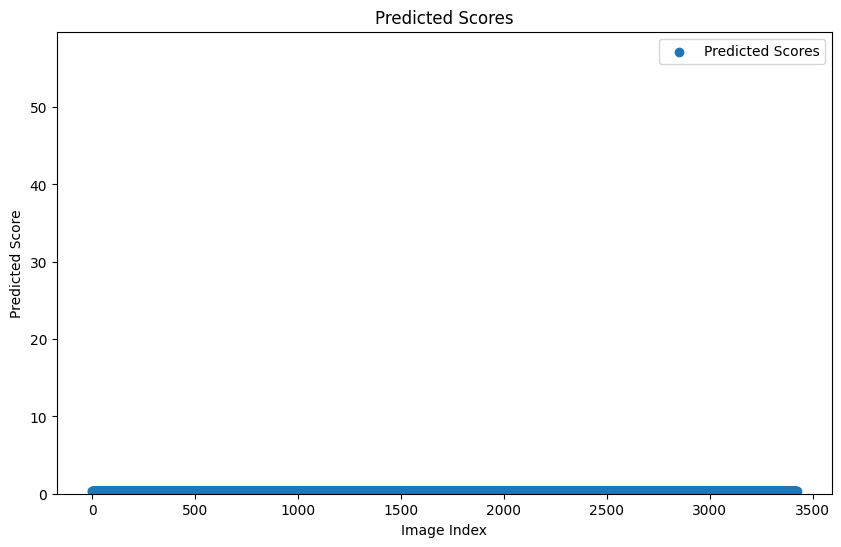

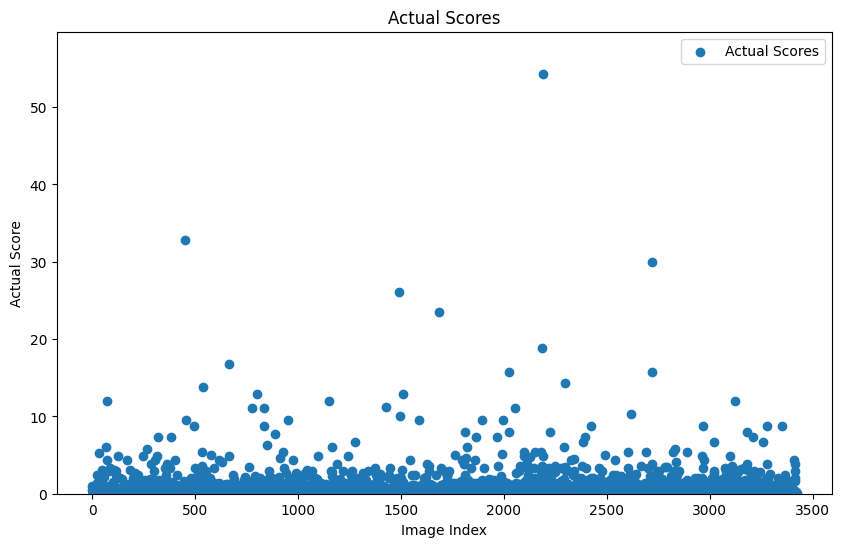

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the predicted_scores list to a numpy array
predicted_scores = np.array(predicted_scores)

# Convert the target scores to a numpy array
actual_scores = np.array(test_scores)

# Get the maximum value of both predicted and actual scores
max_score = max(np.max(predicted_scores), np.max(actual_scores))

# Set the same y-axis limits for both plots
y_min, y_max = 0, max_score * 1.1  # Adjust the factor as needed

# Plotting the predicted scores
plt.figure(figsize=(10, 6))
plt.scatter(range(len(predicted_scores)), predicted_scores, label='Predicted Scores')
plt.xlabel('Image Index')
plt.ylabel('Predicted Score')
plt.title('Predicted Scores')
plt.ylim(y_min, y_max)
plt.legend()
plt.show()

# Plotting the actual scores
plt.figure(figsize=(10, 6))
plt.scatter(range(len(actual_scores)), actual_scores, label='Actual Scores')
plt.xlabel('Image Index')
plt.ylabel('Actual Score')
plt.title('Actual Scores')
plt.ylim(y_min, y_max)
plt.legend()
plt.show()


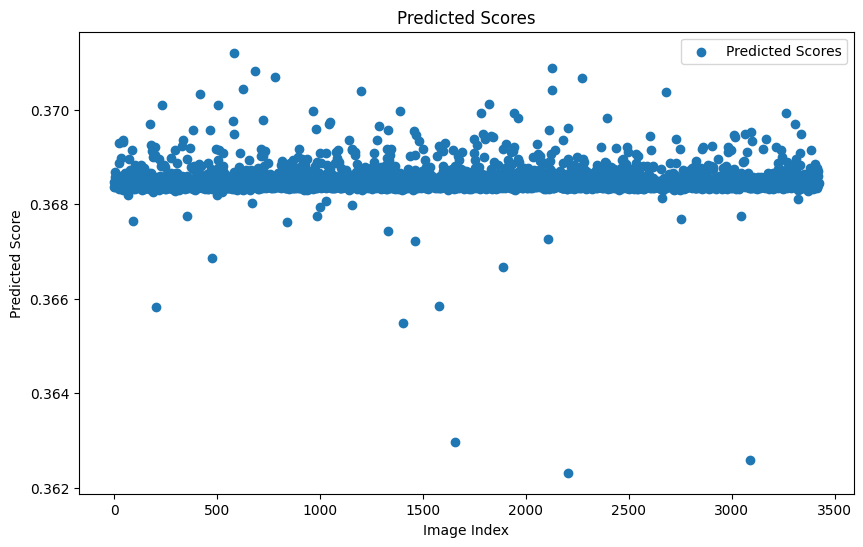

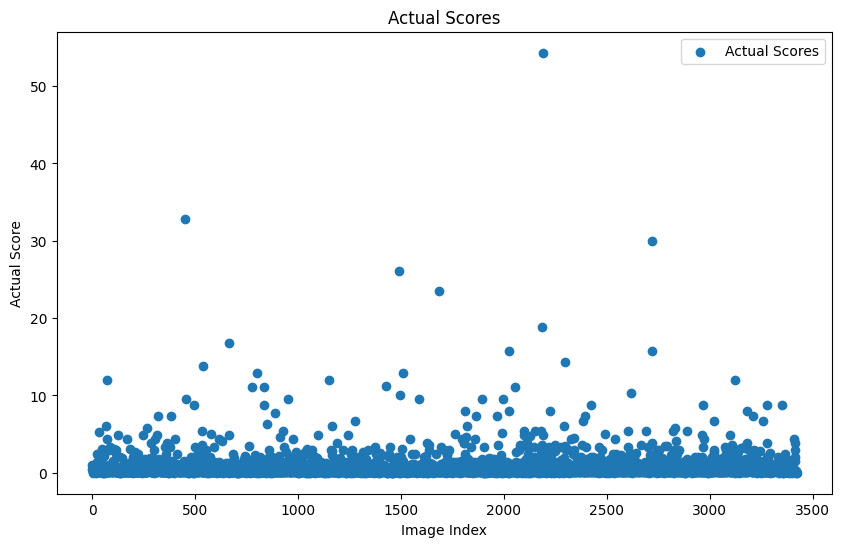

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the predicted_scores list to a numpy array
predicted_scores = np.array(predicted_scores)

# Convert the target scores to a numpy array
actual_scores = np.array(test_scores)

# Plotting the predicted scores
plt.figure(figsize=(10, 6))
plt.scatter(range(len(predicted_scores)), predicted_scores, label='Predicted Scores')
plt.xlabel('Image Index')
plt.ylabel('Predicted Score')
plt.title('Predicted Scores')
plt.legend()
plt.show()

# Plotting the actual scores
plt.figure(figsize=(10, 6))
plt.scatter(range(len(actual_scores)), actual_scores, label='Actual Scores')
plt.xlabel('Image Index')
plt.ylabel('Actual Score')
plt.title('Actual Scores')
plt.legend()
plt.show()


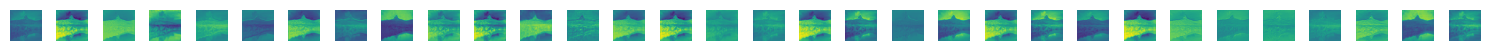

In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_feature_maps(model, input_image, layer_index):
    # Create a forward hook to capture the output of the desired layer
    activations = []
    def hook(module, input, output):
        activations.append(output.detach())
    target_layer = list(model.children())[layer_index]
    hook_handle = target_layer.register_forward_hook(hook)

    # Add a batch dimension to the input image tensor
    input_image = input_image.unsqueeze(0)

    # Pass the input image through the model
    model.eval()
    with torch.no_grad():
        output = model(input_image)

    # Extract the feature maps from the captured activations
    feature_maps = activations[0]

    # Visualize the feature maps
    num_maps = feature_maps.shape[1]
    fig, axes = plt.subplots(1, num_maps, figsize=(15, 3))

    # Denormalize and plot each feature map
    for i in range(num_maps):
        feature_map = feature_maps[0, i].cpu().numpy()
        feature_map = (feature_map - np.min(feature_map)) / (np.max(feature_map) - np.min(feature_map))  # Normalize to [0, 1]
        axes[i].imshow(feature_map)
        axes[i].axis('off')

    # Clean up the hook
    hook_handle.remove()

    # Show the plot
    plt.tight_layout()
    plt.show()

# Assuming you have the trained model and an input image tensor
trained_model = model
input_image = images[5]  # Replace with your input image tensor

# Visualize the feature maps from the first convolutional layer (layer index 0)
visualize_feature_maps(trained_model, input_image, 0)


In [19]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
data_iter = iter(train_loader)
images, scores = next(data_iter)

# Select the first image from the batch
image = images[0]

# Print the shape and other information about the image
print("Image shape:", image.shape)
print("Image tensor:", image)


Image shape: torch.Size([3, 224, 224])
Image tensor: tensor([[[-0.6965, -0.6965, -0.6965,  ..., -0.7822, -0.7822, -0.7822],
         [-0.6965, -0.6965, -0.6794,  ..., -0.7822, -0.7822, -0.7822],
         [-0.6794, -0.6794, -0.6794,  ..., -0.7822, -0.7822, -0.7822],
         ...,
         [-1.6555, -1.6555, -1.7583,  ..., -1.7754, -1.4158, -1.5870],
         [-1.5185, -1.4843, -1.5699,  ..., -1.9809, -1.4672, -1.8953],
         [-1.8439, -1.7412, -1.7412,  ..., -1.9638, -1.2788, -1.8782]],

        [[ 0.9055,  0.9055,  0.9055,  ...,  0.8179,  0.8179,  0.8179],
         [ 0.9055,  0.9055,  0.9230,  ...,  0.8179,  0.8179,  0.8179],
         [ 0.9230,  0.9230,  0.9230,  ...,  0.8179,  0.8179,  0.8179],
         ...,
         [-1.5105, -1.5105, -1.6331,  ..., -1.5280, -1.1604, -1.3354],
         [-1.3880, -1.3529, -1.4405,  ..., -1.6681, -1.1604, -1.5980],
         [-1.7206, -1.6155, -1.6155,  ..., -1.6506, -0.9503, -1.5630]],

        [[ 2.5703,  2.5703,  2.5703,  ...,  2.6051,  2.6051,  2

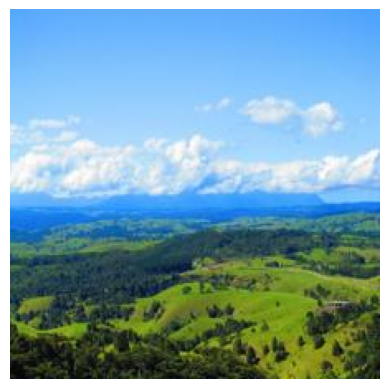

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the image tensor to a numpy array
image_np = image.numpy()

# Transpose the array to match the channel, height, width format
image_np = np.transpose(image_np, (1, 2, 0))

# Denormalize the image by multiplying with the standard deviation and adding the mean
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_np = std * image_np + mean

# Clip the pixel values to the valid range of 0-1
image_np = np.clip(image_np, 0, 1)

# Display the image
plt.imshow(image_np)
plt.axis('off')
plt.show()


Iteration [0/1000], Score: 0.3684
Iteration [100/1000], Score: 0.3761
Iteration [200/1000], Score: 0.3805
Iteration [300/1000], Score: 0.3832
Iteration [400/1000], Score: 0.3858
Iteration [500/1000], Score: 0.3872
Iteration [600/1000], Score: 0.3883
Iteration [700/1000], Score: 0.3898
Iteration [800/1000], Score: 0.3914
Iteration [900/1000], Score: 0.3936


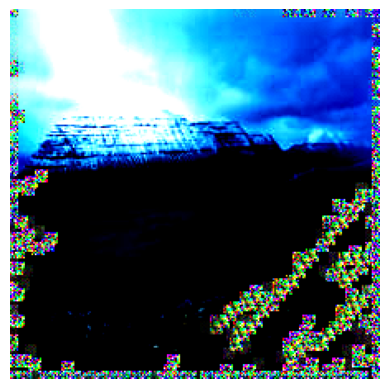

In [25]:
import torch.optim as optim

def optimize_image(image, model, score_target, learning_rate, num_iterations):
    image = image.clone().detach().requires_grad_(True)
    optimizer = optim.Adam([image], lr=learning_rate)

    for iteration in range(num_iterations):
        optimizer.zero_grad()
        output = model(image)
        score = output.squeeze()  # Assuming the model output is a single score
        loss = -score  # We want to maximize the score, so negate it
        loss.backward()
        optimizer.step()

        # Clamp the image pixel values to a valid range (e.g., 0-1 for normalized images)
        image.data.clamp_(0, 1)

        if iteration % 100 == 0:
            print('Iteration [{}/{}], Score: {:.4f}'.format(iteration, num_iterations, score.item()))

        # Check if the desired score target is reached
        if score >= score_target:
            break

    return image

# Assuming you already have the trained model and a sample image tensor
trained_model = model
sample_image = transformed_images[0]  # Use your own image here

# Reshape the sample_image tensor to have 4 dimensions
sample_image = sample_image.unsqueeze(0)

# Set the desired target score for optimization
score_target = 10.0  # Adjust this value based on your requirements

# Set the hyperparameters for optimization
learning_rate = 0.01
num_iterations = 1000

# Perform image optimization
optimized_image = optimize_image(sample_image, trained_model, score_target, learning_rate, num_iterations)

# Visualize the optimized image
import matplotlib.pyplot as plt
plt.imshow(optimized_image.squeeze().permute(1, 2, 0).detach().numpy())
plt.axis('off')
plt.show()


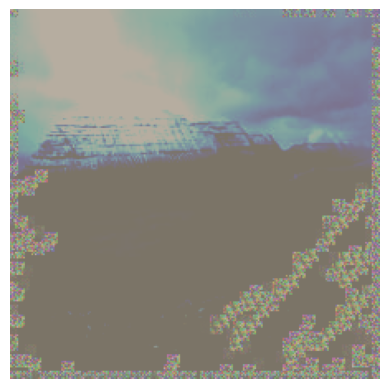

In [27]:

# Denormalize the image by multiplying with the standard deviation and adding the mean
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_np = std * optimized_image.squeeze().permute(1, 2, 0).detach().numpy() + mean

# Plot the denormalized image
plt.imshow(image_np)
plt.axis('off')
plt.show()


In [ ]:


# Create an instance of the model
model = Model().to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Set the number of epochs and the batch size
num_epochs = 10
batch_size = 32

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass, backward pass, and optimization
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i+1) % 2000 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss / 2000}")
            running_loss = 0.0

print("Training finished!")

In [ ]:
# Choose a random image without normalization
image = Image.open("{}/{}".format(image_path, "fl0b5.jpg"))

plt.imshow(image)
plt.show()

# Convert the image to a tensor without normalization
image_tensor = transforms.ToTensor()(image).unsqueeze(0)
img = image_tensor.clone().detach().requires_grad_(True)

# Set up the optimizer
optimizer = optim.Adam([img.requires_grad_()], lr=1e-2)

# Define the target output (near zero)
target = torch.tensor([[0]]).float()

# Run the optimization loop
tv_weight = 1e-6
for i in range(1000):
    optimizer.zero_grad()
    output = model(img)
    loss = criterion(output, target) + tv_weight * torch.sum(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) + tv_weight * torch.sum(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))
    loss.backward()
    optimizer.step()
    
    # Clip the pixel values to stay within [0, 1] range
    img.data = torch.clamp(img.data, 0, 1)
    
    # Print the loss every 100 iterations
    if i % 100 == 0:
        print("Iteration {}: Loss={}".format(i, loss.item()))
        plt.imshow(img.squeeze().permute(1, 2, 0).detach().numpy())
        plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img.squeeze().permute(1, 2, 0).detach().numpy())
plt.show()

### Predicting amount of upvotes

In [ ]:
# Assuming you have the trained model saved as 'model.pth'
model_path = 'model.pth'

# Load the trained model
model = Model()
model.load_state_dict(torch.load(model_path))
model.eval()

# Preprocess the input image
input_image = Image.open('path_to_input_image.jpg')
input_image = input_image.resize((224, 224))
input_tensor = transform(input_image).unsqueeze(0)

# Pass the image through the model
with torch.no_grad():
    output = model(input_tensor)

# Interpret the predicted output
predicted_upvotes = output.item()
print("Predicted upvotes:", predicted_upvotes)


### Feature highlighter

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Assuming you have the trained model saved as 'model.pth'
model_path = 'model.pth'

# Load the trained model
model = Model()
model.load_state_dict(torch.load(model_path))
model.eval()

# Preprocess the input image
input_image = Image.open('path_to_input_image.jpg')
input_image = input_image.resize((224, 224))
input_tensor = transform(input_image).unsqueeze(0)

# Set the model to evaluation mode and disable gradients
model.eval()
input_tensor.requires_grad_()

# Forward pass to obtain the output
output = model(input_tensor)

# Calculate the gradients of the output with respect to the input
output.backward()

# Get the gradients from the input tensor
gradients = input_tensor.grad[0]

# Convert the gradients to grayscale
grayscale_gradients = np.abs(gradients.numpy()).mean(axis=0)

# Normalize the gradients
normalized_gradients = (grayscale_gradients - np.min(grayscale_gradients)) / (
    np.max(grayscale_gradients) - np.min(grayscale_gradients)
)

# Plot the original image and the saliency map
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input_image)
axes[0].axis('off')
axes[0].set_title('Input Image')
axes[1].imshow(normalized_gradients, cmap='hot')
axes[1].axis('off')
axes[1].set_title('Saliency Map')
plt.tight_layout()
plt.show()


Tanker vi kan køre på

Neural Style Transfer
To generate an image that carries over some of the features learned by the network, you can try a technique called "neural style transfer". Neural style transfer involves combining the style of one image with the content of another image using deep neural networks. This technique can be used to generate images that resemble a particular style, while still retaining some of the features of the original content.